In [23]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, classification_report
pd.set_option('display.max_columns',None)
import joblib
import warnings

In [ ]:
n_list = [13]
n_list = range(9, 50, 1)

In [27]:
price_data = pd.read_parquet(f'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Dados_bolsa_interpolar.parquet')

# Configuração inicial
price_data['Date'] = pd.to_datetime(price_data['Date'])
price_data.sort_values(by=['Ticker', 'Date'], inplace=True)

# Cálculo da mudança no preço
price_data['change_in_price'] = price_data['Close'].diff()
mask = price_data['Ticker'] != price_data['Ticker'].shift(1)
price_data['change_in_price'] = np.where(mask, np.nan, price_data['change_in_price'])
price_data[price_data.isna().any(axis = 1)]

# Parâmetros adicionais
t = 14
d = 60
e = 14
n_list = range(9, 50, 1)
alpha = 0.20  # Mantemos um único valor de alpha


# Função de suavização exponencial
def exponential_smoothing(data, alpha):
    smoothed = np.zeros(len(data))
    smoothed[0] = data[0]
    for t in range(1, len(data)):
        smoothed[t] = alpha * data[t] + (1 - alpha) * smoothed[t-1]
    return smoothed

# Função para calcular o target
def calculate_target(data, d):
    return np.sign(data.shift(-d) - data)

# Função para calcular o target e ajustar valores zero para -1
def calculate_target_verify(data, d):
    target = np.sign(data.shift(-d) - data)
    target[target == 0] = -1
    return target

def obv(group):

    Volume = group['Volume']
    change = group['Smoothed_Close'].diff()

    prev_obv = 0
    obv_values = []

    # Calculando o indicador
    for i, j in zip(change, Volume):

        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv

        
        prev_obv = current_obv
        obv_values.append(current_obv)
    
    # Retornando em pandas series
    return pd.Series(obv_values, index = group.index)




price_data['Smoothed_Close'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha)
)


price_data['Prediction'] = price_data.groupby('Ticker')['Smoothed_Close'].transform(
    lambda x: calculate_target_verify(x, d)
)


# Loop para calcular o RSI para cada valor em 'n_list'
for n in n_list:
    # Dias de alta e dias de baixa
    up_df, down_df = price_data[['Ticker', 'change_in_price']].copy(), price_data[['Ticker', 'change_in_price']].copy()

    # Salvando a diferença para dias de alta
    up_df.loc[up_df['change_in_price'] < 0, 'change_in_price'] = 0

    # Salvando a diferença para dias de baixa
    down_df.loc[down_df['change_in_price'] > 0, 'change_in_price'] = 0

    # Colocando as diferenças do dia de baixa em termos absolutos
    down_df['change_in_price'] = down_df['change_in_price'].abs()

    # Calculando o EWMA (Exponential Weighted Moving Average) para dias de alta e baixa
    ewma_up = up_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span=n).mean())
    ewma_down = down_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span=n).mean())

    # Calculando o Relative Strength (RS)
    relative_strength = ewma_up / ewma_down

    # Calculando o Relative Strength Index (RSI)
    relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

    # Salvando o RSI como uma nova coluna no dataframe
    price_data[f'RSI_{n}'] = relative_strength_index

    # Salvando colunas auxiliares para verificação (opcional)
    price_data[f'down_days_{n}'] = down_df['change_in_price']
    price_data[f'up_days_{n}'] = up_df['change_in_price']


# Aplicando a suavização exponencial
alpha_verify = 1
price_data['Smoothed_Close_1'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha_verify)
)


price_data['Verify'] = price_data.groupby('Ticker')['Smoothed_Close_1'].transform(
    lambda x: calculate_target_verify(x, d)
)


# Criação das variáveis low_t e high_t
low_t, high_t = price_data[['Ticker', 'Low']].copy(), price_data[['Ticker', 'High']].copy()
# Cálculo dos valores mínimos e máximos baseados na janela t
low_t = low_t.groupby('Ticker')['Low'].transform(lambda x: x.rolling(window=t).min())
high_t = high_t.groupby('Ticker')['High'].transform(lambda x: x.rolling(window=t).max())

# Cálculo do k_percent
k_percent = 100 * ((price_data['Smoothed_Close'] - low_t) / (high_t - low_t))


# Armazenando os resultados no DataFrame com nomes dinâmicos
price_data[f'low_{t}'] = low_t
price_data[f'high_{t}'] = high_t
price_data[f'k_percent_{t}'] = k_percent


# Calculando o indicador
r_percent = ((high_t - price_data['Smoothed_Close']) / (high_t - low_t)) * (- 100)
price_data[f'r_percent_{t}'] = r_percent

# Price Rate of Change
price_data['Price_Rate_Of_Change'] = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.pct_change(periods = e))

# Calculando o MACD
ema_26 = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

# Calculando a EMA
ema_9_macd = macd.ewm(span = 9).mean()


price_data['MACD'] = macd
price_data['MACD_EMA'] = ema_9_macd



# aplicando a função em cada grupo
obv_groups = price_data.groupby('Ticker').apply(obv)
price_data['On Balance Volume'] = obv_groups.reset_index(level=0, drop=True)


# Aplicando o deslocamento de 10 linhas dentro de cada grupo de 'Ticker'
price_data['Close_10'] = price_data.groupby('Ticker')['Close'].shift(-d)

# Drop linhas com valores ausentes
price_data = price_data.dropna()
# Desativa warnings
warnings.filterwarnings("ignore")
price_data.tail()


,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,RSI_9,down_days_9,up_days_9,RSI_10,down_days_10,up_days_10,RSI_11,down_days_11,up_days_11,RSI_12,down_days_12,up_days_12,RSI_13,down_days_13,up_days_13,RSI_14,down_days_14,up_days_14,RSI_15,down_days_15,up_days_15,RSI_16,down_days_16,up_days_16,RSI_17,down_days_17,up_days_17,RSI_18,down_days_18,up_days_18,RSI_19,down_days_19,up_days_19,RSI_20,down_days_20,up_days_20,RSI_21,down_days_21,up_days_21,RSI_22,down_days_22,up_days_22,RSI_23,down_days_23,up_days_23,RSI_24,down_days_24,up_days_24,RSI_25,down_days_25,up_days_25,RSI_26,down_days_26,up_days_26,RSI_27,down_days_27,up_days_27,RSI_28,down_days_28,up_days_28,RSI_29,down_days_29,up_days_29,RSI_30,down_days_30,up_days_30,RSI_31,down_days_31,up_days_31,RSI_32,down_days_32,up_days_32,RSI_33,down_days_33,up_days_33,RSI_34,down_days_34,up_days_34,RSI_35,down_days_35,up_days_35,RSI_36,down_days_36,up_days_36,RSI_37,down_days_37,up_days_37,RSI_38,down_days_38,up_days_38,RSI_39,down_days_39,up_days_39,RSI_40,down_days_40,up_days_40,RSI_41,down_days_41,up_days_41,RSI_42,down_days_42,up_days_42,RSI_43,down_days_43,up_days_43,RSI_44,down_days_44,up_days_44,RSI_45,down_days_45,up_days_45,RSI_46,down_days_46,up_days_46,RSI_47,down_days_47,up_days_47,RSI_48,down_days_48,up_days_48,RSI_49,down_days_49,up_days_49,Smoothed_Close_1,Verify,low_14,high_14,k_percent_14,r_percent_14,Price_Rate_Of_Change,MACD,MACD_EMA,On Balance Volume,Close_10
11719,2024-10-21,61.349998,61.380001,60.270000,60.330002,59.796291,19044900,VALE3.SA,-0.219997,61.210399,-1.0,33.564365,0.219997,0.000000,34.963251,0.219997,0.000000,36.254923,0.219997,0.000000,37.448437,0.219997,0.000000,38.549257,0.219997,0.000000,39.561996,0.219997,0.000000,40.491366,0.219997,0.000000,41.342375,0.219997,0.000000,42.120257,0.219997,0.000000,42.830317,0.219997,0.000000,43.477796,0.219997,0.000000,44.067762,0.219997,0.000000,44.605033,0.219997,0.000000,45.094135,0.219997,0.000000,45.539281,0.219997,0.000000,45.944364,0.219997,0.000000,46.312959,0.219997,0.000000,46.648341,0.219997,0.000000,46.953497,0.219997,0.000000,47.231146,0.219997,0.000000,47.483762,0.219997,0.000000,47.713588,0.219997,0.000000,47.922660,0.219997,0.000000,48.112823,0.219997,0.000000,48.285749,0.219997,0.000000,48.442955,0.219997,0.000000,48.585814,0.219997,0.000000,48.715571,0.219997,0.000000,48.833355,0.219997,0.000000,48.940190,0.219997,0.000000,49.037006,0.219997,0.000000,49.124647,0.219997,0.000000,49.203881,0.219997,0.000000,49.275404,0.219997,0.000000,49.339851,0.219997,0.000000,49.397801,0.219997,0.000000,49.449780,0.219997,0.000000,49.496269,0.219997,0.000000,49.537708,0.219997,0.000000,49.574496,0.219997,0.000000,49.607001,0.219997,0.000000,60.330002,-1.0,60.250000,65.349998,18.831361,-81.168639,-0.008700,0.687020,0.841824,2525491470,54.020000
11720,2024-10-22,60.150002,60.660000,59.900002,60.410000,59.875580,14814000,VALE3.SA,0.079998,61.050319,-1.0,35.491163,0.000000,0.079998,36.619259,0.000000,0.079998,37.700363,0.000000,0.079998,38.726178,0.000000,0.079998,39.690887,0.000000,0.079998,40.591420,0.000000,0.079998,41.427066,0.000000,0.079998,42.198895,0.000000,0.079998,42.909212,0.000000,0.079998,43.561103,0.000000,0.079998,44.158099,0.000000,0.079998,44.703934,0.000000,0.079998,45.202369,0.000000,0.079998,45.657087,0.000000,0.079998,46.071620,0.000000,0.079998,46.449304,0.000000,0.079998,46.793260,0.000000,0.079998,47.106384,0.000000,0.079998,47.391350,0.000000,0.079998,47.650614,0.000000,0.079998,47.886425,0.000000,0.079998,48.100838,0.000000,0.079998,48.295728,0.000000,0.079998,48.472802,0.000000,0.079998,48.633613,0.000000,0.079998,48.779575,0.000000,0.079998,48.911971,0.000000,0.079998,49.031969,0.000000,0.079998,49.140629,0.000000,0.079998,49.238915,0.000000,0.079998,49.327704,0.000000,0.079998,49.407794,0.000000,0.079998,49.479909,0.000000,0.079998,49.544711,0.000000,0.079998,49.602802,0.000000,0.079998,49.654729,0.000000,0.079998,49.700993,0.000000,0.079998,49.74

In [28]:
price_data = price_data[price_data['Ticker'].isin(['ABEV3.SA'])]
price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,RSI_9,down_days_9,up_days_9,RSI_10,down_days_10,up_days_10,RSI_11,down_days_11,up_days_11,RSI_12,down_days_12,up_days_12,RSI_13,down_days_13,up_days_13,RSI_14,down_days_14,up_days_14,RSI_15,down_days_15,up_days_15,RSI_16,down_days_16,up_days_16,RSI_17,down_days_17,up_days_17,RSI_18,down_days_18,up_days_18,RSI_19,down_days_19,up_days_19,RSI_20,down_days_20,up_days_20,RSI_21,down_days_21,up_days_21,RSI_22,down_days_22,up_days_22,RSI_23,down_days_23,up_days_23,RSI_24,down_days_24,up_days_24,RSI_25,down_days_25,up_days_25,RSI_26,down_days_26,up_days_26,RSI_27,down_days_27,up_days_27,RSI_28,down_days_28,up_days_28,RSI_29,down_days_29,up_days_29,RSI_30,down_days_30,up_days_30,RSI_31,down_days_31,up_days_31,RSI_32,down_days_32,up_days_32,RSI_33,down_days_33,up_days_33,RSI_34,down_days_34,up_days_34,RSI_35,down_days_35,up_days_35,RSI_36,down_days_36,up_days_36,RSI_37,down_days_37,up_days_37,RSI_38,down_days_38,up_days_38,RSI_39,down_days_39,up_days_39,RSI_40,down_days_40,up_days_40,RSI_41,down_days_41,up_days_41,RSI_42,down_days_42,up_days_42,RSI_43,down_days_43,up_days_43,RSI_44,down_days_44,up_days_44,RSI_45,down_days_45,up_days_45,RSI_46,down_days_46,up_days_46,RSI_47,down_days_47,up_days_47,RSI_48,down_days_48,up_days_48,RSI_49,down_days_49,up_days_49,Smoothed_Close_1,Verify,low_14,high_14,k_percent_14,r_percent_14,Price_Rate_Of_Change,MACD,MACD_EMA,On Balance Volume,Close_10
5686,2024-10-17,12.78,12.96,12.75,12.86,12.613667,18266900,ABEV3.SA,-0.08,13.033806,-1.0,27.957329,0.08,0.00,30.229525,0.08,0.00,32.182699,0.08,0.00,33.867364,0.08,0.00,35.330080,0.08,0.00,36.610573,0.08,0.00,37.741499,0.08,0.00,38.749199,0.08,0.00,39.654728,0.08,0.00,40.474861,0.08,0.00,41.222961,0.08,0.00,41.909703,0.08,0.00,42.543649,0.08,0.00,43.131707,0.08,0.00,43.679481,0.08,0.00,44.191557,0.08,0.00,44.671712,0.08,0.00,45.123089,0.08,0.00,45.548323,0.08,0.00,45.949643,0.08,0.00,46.328956,0.08,0.00,46.687906,0.08,0.00,47.027925,0.08,0.00,47.350271,0.08,0.00,47.656057,0.08,0.00,47.946281,0.08,0.00,48.221838,0.08,0.00,48.483542,0.08,0.00,48.732136,0.08,0.00,48.968301,0.08,0.00,49.192667,0.08,0.00,49.405816,0.08,0.00,49.608294,0.08,0.00,49.800609,0.08,0.00,49.983236,0.08,0.00,50.156626,0.08,0.00,50.321201,0.08,0.00,50.477361,0.08,0.00,50.625484,0.08,0.00,50.765929,0.08,0.00,50.899038,0.08,0.00,12.86,-1.0,12.72,13.85,27.770412,-72.229588,0.013629,0.104235,0.131437,-1995026547,11.25
5687,2024-10-18,12.96,12.96,12.80,12.88,12.633285,19422900,ABEV3.SA,0.02,13.003045,-1.0,31.435630,0.00,0.02,33.146896,0.00,0.02,34.679158,0.00,0.02,36.040063,0.00,0.02,37.248139,0.00,0.02,38.324338,0.00,0.02,39.288451,0.00,0.02,40.157802,0.00,0.02,40.946996,0.00,0.02,41.668103,0.00,0.02,42.330996,0.00,0.02,42.943712,0.00,0.02,43.512795,0.00,0.02,44.043580,0.00,0.02,44.540438,0.00,0.02,45.006968,0.00,0.02,45.446155,0.00,0.02,45.860494,0.00,0.02,46.252090,0.00,0.02,46.622734,0.00,0.02,46.973963,0.00,0.02,47.307112,0.00,0.02,47.623351,0.00,0.02,47.923713,0.00,0.02,48.209120,0.00,0.02,48.480403,0.00,0.02,48.738313,0.00,0.02,48.983539,0.00,0.02,49.216713,0.00,0.02,49.438419,0.00,0.02,49.649203,0.00,0.02,49.849571,0.00,0.02,50.039999,0.00,0.02,50.220938,0.00,0.02,50.392808,0.00,0.02,50.556011,0.00,0.02,50.710925,0.00,0.02,50.857912,0.00,0.02,50.997315,0.00,0.02,51.129459,0.00,0.02,51.254657,0.00,0.02,12.88,-1.0,12.75,13.85,23.004063,-76.995937,0.011529,0.089332,0.123016,-2014449447,11.02
5688,2024-10-21,12.88,12.94,12.81,12.83,12.584243,28877400,ABEV3.SA,-0.05,12.968436,-1.0,27.314533,0.05,0.00,29.391746,0.05,0.00,31.230316,0.05,0.00,32.851324,0.05,0.00,34.282548,0.05,0.00,35.551811,0.05,0.00,36.684211,0.05,0.00,37.701271,0.05,0.00,38.620959,0.05,0.00,39.458062,0.05,0.00,40.224661,0.05,0.00,40.930606,0.05,0.00,41.583933,0.05,0.00,42.191215,0.05,0.00,42.757850,0.05,0.00,43.288303,0.05,0.00,43.786286,0.05,0.00,44.254910,0.05,0.00,44.696802,0.05,0.00,45.114202,0.05,0.00,45.509033,0.05,0.00,45.882961

n: 9
Fold 1:
 - Correct Prediction (y_test): 40.70%
 - Correct Prediction (Verify): 41.12%
Fold 2:
 - Correct Prediction (y_test): 48.20%
 - Correct Prediction (Verify): 48.20%
Fold 3:
 - Correct Prediction (y_test): 52.64%
 - Correct Prediction (Verify): 51.59%
Fold 4:
 - Correct Prediction (y_test): 60.78%
 - Correct Prediction (Verify): 60.99%
Fold 5:
 - Correct Prediction (y_test): 46.19%
 - Correct Prediction (Verify): 46.51%
Média de acurácia (y_test) para n 9: 49.70%
Média de acurácia (Verify) para n 9: 49.68%
---
n: 10
Fold 1:
 - Correct Prediction (y_test): 40.91%
 - Correct Prediction (Verify): 41.33%
Fold 2:
 - Correct Prediction (y_test): 46.93%
 - Correct Prediction (Verify): 46.93%
Fold 3:
 - Correct Prediction (y_test): 52.43%
 - Correct Prediction (Verify): 51.16%
Fold 4:
 - Correct Prediction (y_test): 61.31%
 - Correct Prediction (Verify): 61.52%
Fold 5:
 - Correct Prediction (y_test): 46.19%
 - Correct Prediction (Verify): 46.30%
Média de acurácia (y_test) para n 10:

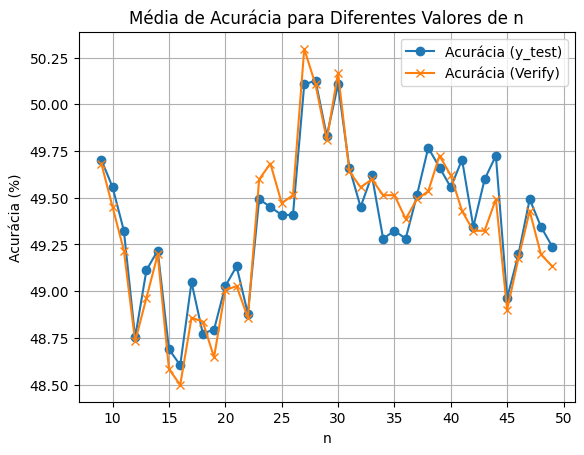

In [29]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
import winsound

# Definir o número de divisões para a validação cruzada
n_splits = 5

# Criar listas para armazenar os resultados gerais
all_predictions = []
all_verify_values = []
all_actual_values = []
all_accuracy_scores_ytest = []
all_accuracy_scores_verify = []

# Criar uma lista para armazenar as médias das acurácias por n
mean_accuracy_by_n = []

# Loop para cada n em n_list e realização de validação cruzada em série temporal
for n in n_list:
    # Definir as features (X), o target (y) e a verificação (verify) dinamicamente
    X = price_data[[f'RSI_{n}',
                    f'k_percent_{t}',
                    f'r_percent_{t}',
                    'Price_Rate_Of_Change',
                    'MACD',
                    'MACD_EMA',
                    f'On Balance Volume']]
    y = price_data[f'Prediction']
    verify = price_data['Verify']

    # Remover possíveis valores NaN nas colunas selecionadas
    data = pd.concat([X, y, verify], axis=1).dropna()
    X = data.iloc[:, :-2]
    y = data.iloc[:, -2]
    verify = data.iloc[:, -1]

    # Configurar o TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Listas para armazenar as acurácias por fold para esse n
    accuracy_scores_ytest_fold = []
    accuracy_scores_verify_fold = []



    print(f'n: {n}')
    fold = 1
    for train_index, test_index in tscv.split(X):
        # Dividir os dados em treino e teste com base nos índices
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        y_verify = verify.iloc[test_index]

        # Criar o modelo de Random Forest
        rand_frst_clf = RandomForestClassifier(n_estimators=100, criterion="gini", random_state=0, oob_score=True)

        # Ajustar o modelo aos dados de treino
        rand_frst_clf.fit(X_train, y_train)

        # Fazer previsões nos dados de teste
        y_pred = rand_frst_clf.predict(X_test)

        # Armazenar as predições e valores reais para análise posterior
        all_predictions.extend(y_pred)
        all_verify_values.extend(y_verify.values)
        all_actual_values.extend(y_test.values)

        # Calcular acurácia para y_test e verify
        accuracy_ytest = accuracy_score(y_test, y_pred) * 100.0
        accuracy_verify = accuracy_score(y_verify, y_pred) * 100.0

        # Armazenar as acurácias por fold
        accuracy_scores_ytest_fold.append(accuracy_ytest)
        accuracy_scores_verify_fold.append(accuracy_verify)

        # Exibir resultados por fold
        print(f'Fold {fold}:')
        print(f' - Correct Prediction (y_test): {accuracy_ytest:.2f}%')
        print(f' - Correct Prediction (Verify): {accuracy_verify:.2f}%')
        fold += 1

    # Calcular a média de acurácia por n
    mean_accuracy_ytest = np.mean(accuracy_scores_ytest_fold)
    mean_accuracy_verify = np.mean(accuracy_scores_verify_fold)
    mean_accuracy_by_n.append((n, mean_accuracy_ytest, mean_accuracy_verify))

    print(f'Média de acurácia (y_test) para n {n}: {mean_accuracy_ytest:.2f}%')
    print(f'Média de acurácia (Verify) para n {n}: {mean_accuracy_verify:.2f}%')
    print('---')

# Exibir o resumo geral das médias
print("Resumo geral das médias:")
for n, acc_ytest, acc_verify in mean_accuracy_by_n:
    print(f'n: {n} - Média Acurácia (y_test): {acc_ytest:.2f}% - Média Acurácia (Verify): {acc_verify:.2f}%')

# Opcional: Plotando as médias por n
import matplotlib.pyplot as plt

n_values, acc_ytest_values, acc_verify_values = zip(*mean_accuracy_by_n)

plt.plot(n_values, acc_ytest_values, label='Acurácia (y_test)', marker='o')
plt.plot(n_values, acc_verify_values, label='Acurácia (Verify)', marker='x')
plt.title("Média de Acurácia para Diferentes Valores de n")
plt.xlabel('n')
plt.ylabel('Acurácia (%)')
plt.legend()
plt.grid(True)
plt.show()
winsound.Beep(440, 300)


#### Caso apareça erro float 32

n: 2
Fold 1:
 - Correct Prediction (y_test): 41.99%
 - Correct Prediction (Verify): 41.77%
Fold 2:
 - Correct Prediction (y_test): 46.37%
 - Correct Prediction (Verify): 47.12%
Fold 3:
 - Correct Prediction (y_test): 53.85%
 - Correct Prediction (Verify): 53.31%
Fold 4:
 - Correct Prediction (y_test): 49.04%
 - Correct Prediction (Verify): 49.68%
Fold 5:
 - Correct Prediction (y_test): 49.15%
 - Correct Prediction (Verify): 47.76%
Média de acurácia (y_test) para n 2: 48.08%
Média de acurácia (Verify) para n 2: 47.93%
---
n: 4
Fold 1:
 - Correct Prediction (y_test): 48.16%
 - Correct Prediction (Verify): 47.85%
Fold 2:
 - Correct Prediction (y_test): 47.74%
 - Correct Prediction (Verify): 49.00%
Fold 3:
 - Correct Prediction (y_test): 50.58%
 - Correct Prediction (Verify): 50.68%
Fold 4:
 - Correct Prediction (y_test): 51.52%
 - Correct Prediction (Verify): 51.63%
Fold 5:
 - Correct Prediction (y_test): 46.07%
 - Correct Prediction (Verify): 45.65%
Média de acurácia (y_test) para n 4: 4

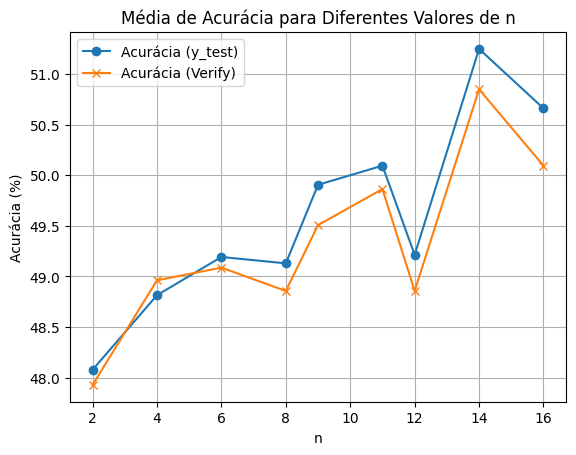

In [22]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
import winsound


# Definir o número de divisões para a validação cruzada
n_splits = 5

# Criar listas para armazenar os resultados gerais
all_predictions = []
all_verify_values = []
all_actual_values = []
all_accuracy_scores_ytest = []
all_accuracy_scores_verify = []

# Criar uma lista para armazenar as médias das acurácias por n
mean_accuracy_by_n = []

for n in n_list:
    X = price_data[['RSI',
                    f'k_percent_{alpha:.2f}_n{n}',
                    f'r_percent_{alpha:.2f}_n{n}',
                    f'Price_Rate_Of_Change_{alpha:.2f}_n{n}',
                    f'MACD_{alpha:.2f}_n{n}',
                    f'MACD_EMA_{alpha:.2f}_n{n}',
                    f'OBV_{alpha:.2f}_n{n}']]
    y = price_data[f'Prediction_{alpha:.2f}_n{n}']
    verify = price_data['Verify']

    # Concatenar e tratar NaN
    data = pd.concat([X, y, verify], axis=1).replace([np.inf, -np.inf], np.nan).dropna()
    X = data.iloc[:, :-2]
    y = data.iloc[:, -2]
    verify = data.iloc[:, -1]


    # Converter para float32
    X = X.astype(np.float32)

    # Configurar TimeSeriesSplit e o resto do código
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Listas para armazenar as acurácias por fold para esse n
    accuracy_scores_ytest_fold = []
    accuracy_scores_verify_fold = []



    print(f'n: {n}')
    fold = 1
    for train_index, test_index in tscv.split(X):
        # Dividir os dados em treino e teste com base nos índices
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        y_verify = verify.iloc[test_index]

        # Criar o modelo de Random Forest
        rand_frst_clf = RandomForestClassifier(n_estimators=100, criterion="gini", random_state=0, oob_score=True)

        # Ajustar o modelo aos dados de treino
        rand_frst_clf.fit(X_train, y_train)

        # Fazer previsões nos dados de teste
        y_pred = rand_frst_clf.predict(X_test)

        # Armazenar as predições e valores reais para análise posterior
        all_predictions.extend(y_pred)
        all_verify_values.extend(y_verify.values)
        all_actual_values.extend(y_test.values)

        # Calcular acurácia para y_test e verify
        accuracy_ytest = accuracy_score(y_test, y_pred) * 100.0
        accuracy_verify = accuracy_score(y_verify, y_pred) * 100.0

        # Armazenar as acurácias por fold
        accuracy_scores_ytest_fold.append(accuracy_ytest)
        accuracy_scores_verify_fold.append(accuracy_verify)

        # Exibir resultados por fold
        print(f'Fold {fold}:')
        print(f' - Correct Prediction (y_test): {accuracy_ytest:.2f}%')
        print(f' - Correct Prediction (Verify): {accuracy_verify:.2f}%')
        fold += 1

    # Calcular a média de acurácia por n
    mean_accuracy_ytest = np.mean(accuracy_scores_ytest_fold)
    mean_accuracy_verify = np.mean(accuracy_scores_verify_fold)
    mean_accuracy_by_n.append((n, mean_accuracy_ytest, mean_accuracy_verify))

    print(f'Média de acurácia (y_test) para n {n}: {mean_accuracy_ytest:.2f}%')
    print(f'Média de acurácia (Verify) para n {n}: {mean_accuracy_verify:.2f}%')
    print('---')

# Exibir o resumo geral das médias
print("Resumo geral das médias:")
for n, acc_ytest, acc_verify in mean_accuracy_by_n:
    print(f'n: {n} - Média Acurácia (y_test): {acc_ytest:.2f}% - Média Acurácia (Verify): {acc_verify:.2f}%')

# Opcional: Plotando as médias por n
import matplotlib.pyplot as plt

n_values, acc_ytest_values, acc_verify_values = zip(*mean_accuracy_by_n)

plt.plot(n_values, acc_ytest_values, label='Acurácia (y_test)', marker='o')
plt.plot(n_values, acc_verify_values, label='Acurácia (Verify)', marker='x')
plt.title("Média de Acurácia para Diferentes Valores de n")
plt.xlabel('n')
plt.ylabel('Acurácia (%)')
plt.legend()
plt.grid(True)
plt.show()
winsound.Beep(440, 300)